## Transfer Learning on Cats-Dogs Classification - Fine Tune

#### Finetune MobileNet-V2 top layers and classification layers to classify cats vs. dogs.
Adapted from https://www.tensorflow.org/tutorials/images/transfer_learning

### CIML Summer Institute
Mai H. Nguyen, UC San Diego

-----

### Setup

In [1]:
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

In [2]:
print (tf.__version__)
!python --version

2.5.0
Python 3.6.9


In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
!nvidia-smi

Wed Jun 29 12:28:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   39C    P0    41W / 300W |      3MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Set logging level
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
# Set random generator seed
seed = 1234

# Disable hash randomization by specifying the value 0.
os.environ['PYTHONHASHSEED'] = '0'

# Set numpy random generator
np.random.seed(seed)

# Set python built-in random generator
random.seed(seed)

# Set tf global random seed
tf.random.set_seed(seed)

# Set tensorflow graph-level random seed
tf.compat.v1.random.set_random_seed(seed)

# Potential randomness from CUDNN
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC']= '1'

### Set image location and dimensions

In [7]:
from os.path import expanduser
HOME = expanduser("~")

data_path = HOME + '/data/catsVsDogs'

# Location of images
train_data_dir = data_path + '/train'
val_data_dir   = data_path + '/val'
test_data_dir  = data_path + '/test'

print ('Train path:' + train_data_dir)
print ('Validation path:' + val_data_dir)
print ('Test path:' + test_data_dir)

Train path:/home/xdtr102/data/catsVsDogs/train
Validation path:/home/xdtr102/data/catsVsDogs/val
Test path:/home/xdtr102/data/catsVsDogs/test


In [8]:
# Image dimensions
img_width, img_height = 224, 224 
IMG_SIZE = (img_width,img_height)
IMG_SHAPE = IMG_SIZE + (3,)

### Prepare data

In [9]:
# Batch size
BATCH_SIZE = 16

# Data setup
rescale = tf.keras.applications.mobilenet_v2.preprocess_input
train_datagen      = ImageDataGenerator(shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, preprocessing_function = rescale)
validation_datagen = ImageDataGenerator(preprocessing_function = rescale)
test_datagen       = ImageDataGenerator(preprocessing_function = rescale)

# Set up generator to read images found in subfolders of training data directory,
# and indefinitely generate batches of image data (scaled).  This is for training data.
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode='binary', 
                                                    shuffle = True,
                                                    seed = seed)           

# Set up generator to generate batched of validation data for model
validation_generator = validation_datagen.flow_from_directory(val_data_dir,
                                                              target_size=IMG_SIZE,
                                                              batch_size = BATCH_SIZE,
                                                              class_mode='binary',
                                                              shuffle = False, 
                                                              seed = seed)
# Set up generator to generate batched of test data for model
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=IMG_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  class_mode='binary',
                                                  shuffle = False,
                                                  seed = seed)

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


### Load model from feature extraction
Load model saved from feature extraction.  Weights in last blocks and top model will be adjusted.  All other weights are frozen.

In [10]:
model = tf.keras.models.load_model('models/features_model')

In [11]:
# Uncomment to list layers in model
# list(enumerate(model.layers[0].layers))

In [12]:
## Freeze all weights of model up to Block 14
model.trainable = True
for i, layers in enumerate(model.layers[0].layers):
    if i < 116:layers.trainable = False
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,682,625
Non-trainable params: 576,640
_________________________________________________________________


### Fine tune model

In [13]:
EPOCHS = 20

# Compile model with very slow learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
              loss= losses.BinaryCrossentropy(),metrics=['accuracy'])

# Perform early stopping to avoid overfitting and ModelCheckpoint to save the best model
checkpoint_path = 'tmp/checkpoint'
callbacks = [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001, mode='min'),
             ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', mode = 'min', 
                             save_best_only = True, save_weights_only=True)]

In [14]:
%%time

train_history = model.fit(train_generator,epochs=EPOCHS, 
                          validation_data=validation_generator, 
                          callbacks=callbacks)

Epoch 1/20
125/125 [==============================] - 24s 157ms/step - loss: 0.2842 - accuracy: 0.8785 - val_loss: 0.0845 - val_accuracy: 0.9800
Epoch 2/20
125/125 [==============================] - 19s 152ms/step - loss: 0.1427 - accuracy: 0.9540 - val_loss: 0.0679 - val_accuracy: 0.9750
Epoch 3/20
125/125 [==============================] - 19s 151ms/step - loss: 0.1085 - accuracy: 0.9605 - val_loss: 0.0568 - val_accuracy: 0.9750
Epoch 4/20
125/125 [==============================] - 19s 155ms/step - loss: 0.1061 - accuracy: 0.9635 - val_loss: 0.0469 - val_accuracy: 0.9775
Epoch 5/20
125/125 [==============================] - 19s 152ms/step - loss: 0.0734 - accuracy: 0.9780 - val_loss: 0.0459 - val_accuracy: 0.9775
Epoch 6/20
125/125 [==============================] - 19s 152ms/step - loss: 0.0742 - accuracy: 0.9740 - val_loss: 0.0433 - val_accuracy: 0.9775
Epoch 7/20
125/125 [==============================] - 19s 152ms/step - loss: 0.0649 - accuracy: 0.9755 - val_loss: 0.0444 - val_ac

In [15]:
# Load the best model that was saved using ModelCheckpoint
model.load_weights(checkpoint_path)

In [16]:
# Save weights from finetuning
model.save("models/finetune_model")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


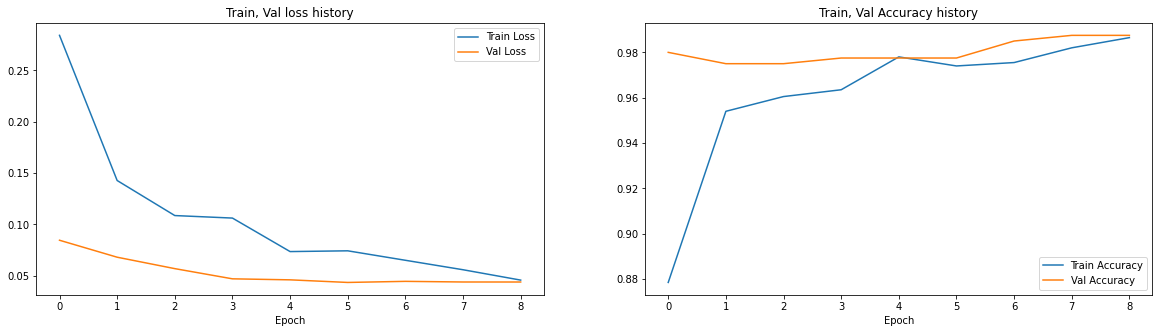

In [17]:
# Plot train and validation loss
fig, axs = plt.subplots(1,2, figsize= (20,5))
axs[0].plot(train_history.history['loss'])
axs[0].plot(train_history.history['val_loss'])
axs[0].set_title("Train, Val loss history")
axs[0].set_xlabel("Epoch")
axs[0].legend(["Train Loss","Val Loss"])

# Plot train and validation accuracy
axs[1].plot(train_history.history['accuracy'])
axs[1].plot(train_history.history['val_accuracy'])
axs[1].set_title("Train, Val Accuracy history")
axs[1].set_xlabel("Epoch")
axs[1].legend(["Train Accuracy","Val Accuracy"])

### Evaluate model

In [18]:
_, train_accuracy = model.evaluate(train_generator)
print("Train data accuracy:", train_accuracy)

_, test_accuracy = model.evaluate(test_generator)
print("Test data accuracy:", test_accuracy)

125/125 [==============================] - 19s 150ms/step - loss: 0.0173 - accuracy: 0.9970
Train data accuracy: 0.996999979019165
25/25 [==============================] - 1s 43ms/step - loss: 0.0278 - accuracy: 0.9900
Test data accuracy: 0.9900000095367432


In [19]:
# Get predicted value and the ground truth value of test data
pred = (model.predict(test_generator) > 0.5).astype("int32")
true = test_generator.classes

In [20]:
# Get evaluation metrics for test data
print(classification_report(y_true= true, y_pred = pred, target_names=['cats', 'dogs']))

              precision    recall  f1-score   support

        cats       0.99      0.99      0.99       200
        dogs       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



### Perform inference on test images

In [21]:
def image_loader(img_file):
    """load individual images"""
    img = load_img(img_file, target_size = (img_width, img_height))
    imgplot = plt.imshow(img)
    plt.show()
    # img = img_to_array(img) / 255
    img = (img_to_array(img)/127.5)-1.0
    img = np.expand_dims(img, axis = 0) #model input is (1,150,150,3)
    return img

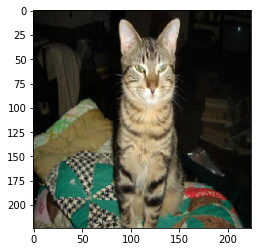

[[0.00099]]


In [22]:
test_image = data_path + '/test/cats/cat.1070.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

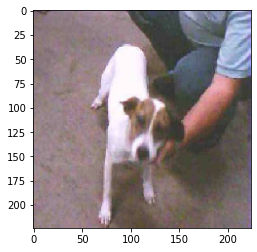

[[0.99988]]


In [23]:
test_image = data_path + '/test/dogs/dog.1233.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

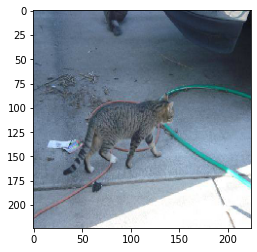

[[0.27286]]


In [24]:
test_image = data_path + '/test/cats/cat.1080.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

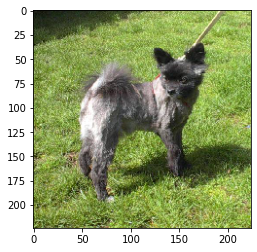

[[0.86656]]


In [25]:
test_image = data_path + '/test/dogs/dog.1132.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

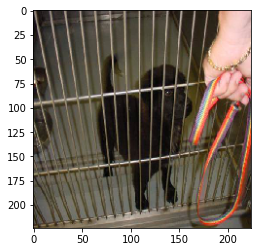

[[0.21613]]


In [26]:
test_image = data_path + '/test/dogs/dog.1311.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

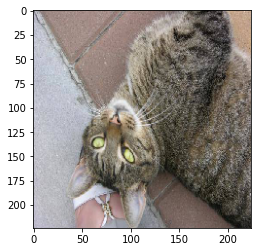

[[0.03269]]


In [27]:
test_image = data_path + '/test/cats/cat.1338.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

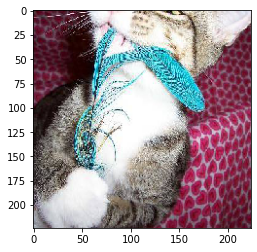

[[0.08519267]]


In [28]:
test_image = data_path + '/test/cats/cat.1342.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(img_y_pred)

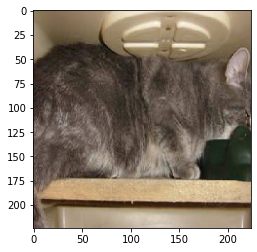

[[0.00054]]


In [29]:
test_image = data_path + '/test/cats/cat.1180.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

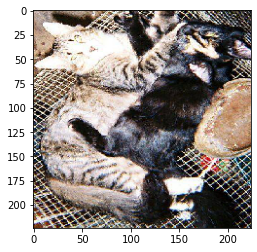

[[0.3034]]


In [30]:
test_image = data_path + '/test/cats/cat.1048.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

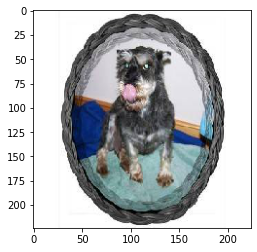

[[0.99739]]


In [31]:
test_image = data_path + '/test/dogs/dog.1342.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))